In [1]:
"""
This program will create the EOM for a CDPM with a horizontal plate (the platform) attached 
to the two cables. It will then export the equations to a csv file.
"""
from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
init_printing(use_latex='mathjax')
# import seaborn as sns
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import matplotlib.pyplot as plt
from scipy.integrate import ode, odeint
import numpy as np
import InputShaping as shaping
import Length_calcs
# import testing as Length_calcs
%matplotlib inline

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Constants
plate_width = 4.0
plate_height = 2.0
plate_mass = 10.0

rod_mass = 2.0
rod_length = 4.0

initial_x = 10.0
initial_y = 11.0

end_x = 9.0
end_y = 12.0

# This will make the cables the correct lengths. Or define the lengths yourself.
L1_begin, L2_begin = Length_calcs.Lengths(initial_x, initial_y)
L1_end, L2_end = Length_calcs.Lengths(end_x, end_y)
time_begin = 0.5
Rise_time = np.sqrt((initial_x-end_x)**2 + (initial_y - end_y)**2)*(3/4)

In [3]:
# Create the variables
x, y, beta, e, F, f = me.dynamicsymbols('x, y, beta e F f')

# Create the velocities
x_dot, y_dot, beta_dot, e_dot = me.dynamicsymbols('x, y, beta e', 1)

# Create the constants
m, k, L, g, H, c, D, t, a, b, m_rod, k_rod, c_rod = sympy.symbols('m k L g H c D t a b m_rod k_rod c_rod')
Izz, Izz_rod, k_beta, c_beta = sympy.symbols('Izz Izz_rod k_beta c_beta')
L_1_init, L_2_init = sympy.symbols('L_1_init L_2_init')
'''
m = mass
k = spring k
L = spring equilibrium length
g = gravity
c = spring c
c_beta = rotational c
k_beta = rotational k
D = rod length
Izz = moment of Inertia about the end of a rod
a = plate width
b = plate height
e = distance from rod CoG and plate CoG
F = force applied to the rod allowing it to move.

'''

# Create the world frame
N = me.ReferenceFrame('N')

# Create the plate frame
B = N.orientnew('B', 'axis', [beta, N.z])

# Set the rotation of the plate frame
# B.set_ang_vel(N, -beta_dot * N.z)

# phi = sympy.atan2((x-(a/2)*sympy.cos(beta)) , (y-(a/2)*sympy.sin(beta)))
# phi_dot = sympy.atan2((x-(a/2)*sympy.cos(beta_dot)) , (y-(a/2)*sympy.sin(beta_dot)))

# # Create the plate frame
# A = N.orientnew('A', 'axis', [phi, N.z])
# A.set_ang_vel(N, phi_dot * N.z)

# Create the Origin
O1 = me.Point('O_1')

# Set origin velocity to zero
O1.set_vel(N, 0)
# O1.set_vel(B, 0)

# Create the second attachment point
# O2 = O1.locatenew('O_2', H * N.x)
O2 = me.Point('O_2')
O2.set_pos(O1, H * N.x)
O2.set_vel(N, 0)
# O2.set_vel(B, 0)

In [4]:
G = O1.locatenew('G', x * N.x + y * N.y)
# G = me.Point('G')
# G.set_pos(P1, (a/2) * B.x)
# G.set_pos(O1, x * N.x + y * N.y)
G.set_pos(O2, -(H-x) * N.x + y * N.y)
G.set_vel(N, x_dot * N.x + y_dot * N.y)
G.set_vel(B, 0)

In [5]:
P1 = G.locatenew('P1', -(a/2) * B.x - (b/2) * B.y)
P1.set_vel(B, 0)
P1.v2pt_theory(G, N, B)

d       
──(x(t))
dt       n_x + d       
──(y(t))
dt       n_y +   d       
b⋅──(β(t))
  dt      
──────────
    2      b_x +    d        
-a⋅──(β(t)) 
   dt       
────────────
     2       b_y

In [6]:
P2 = G.locatenew('P2', (a/2) * B.x - (b/2) * B.y)
P2.set_vel(B,0)
P2.v2pt_theory(G, N, B)

d       
──(x(t))
dt       n_x + d       
──(y(t))
dt       n_y +   d       
b⋅──(β(t))
  dt      
──────────
    2      b_x +   d       
a⋅──(β(t))
  dt      
──────────
    2      b_y

In [7]:
Z_G = O1.locatenew('Z_G', x * N.x + y * N.y - e * B.y)
Z_G.set_pos(G, -e * B.y)
Z_G.set_vel(B, -e_dot * B.y)
Z_G.v1pt_theory(G, N, B)

     d       
e(t)⋅──(β(t))
     dt       b_x +  d       
-──(e(t))
 dt       b_y + d       
──(x(t))
dt       n_x + d       
──(y(t))
dt       n_y

In [8]:
Z_bottom = Z_G.locatenew('Z_bottom', (D/2) * B.y)
Z_bottom.v2pt_theory(Z_G, N, B)

⎛    d                       ⎞
⎜  D⋅──(β(t))                ⎟
⎜    dt              d       ⎟
⎜- ────────── + e(t)⋅──(β(t))⎟
⎝      2             dt      ⎠ b_x +  d       
-──(e(t))
 dt       b_y + d       
──(x(t))
dt       n_x + d       
──(y(t))
dt       n_y

In [9]:
Z_top = Z_G.locatenew('Z_top', -(D/2) * B.y)
Z_top.v2pt_theory(Z_G, N, B)

⎛  d                       ⎞
⎜D⋅──(β(t))                ⎟
⎜  dt              d       ⎟
⎜────────── + e(t)⋅──(β(t))⎟
⎝    2             dt      ⎠ b_x +  d       
-──(e(t))
 dt       b_y + d       
──(x(t))
dt       n_x + d       
──(y(t))
dt       n_y

In [10]:
# Create the plate
I_plate = me.inertia(B, 0, 0, Izz)
plate = me.RigidBody('plate', G, B, m, (I_plate, G))

# Create the distance from the point to each attachment point
L1 = O1.pos_from(P1).magnitude()
L2 = O2.pos_from(P2).magnitude()
L1_vector = O1.pos_from(P1).normalize()
L2_vector = O2.pos_from(P2).normalize()

# Create the height from the center of gravity to the datum
h = G.pos_from(O1) & N.y

In [11]:
# L1_vectora = P1.pos_from(O1).normalize()
# L2_vectora = P2.pos_from(O2).normalize()

# L1_0, L2_0, k1, k2 = sympy.symbols('L1_p L2_p k1 k2')
# L1_vector_N = L1_vectora.express(N)
# L2_vector_N = L2_vectora.express(N)
# Fsp_1 = k1*(L1_0)
# Fsp_2 = k2*(L2_0)
# Fsp_1_x = (Fsp_1 * L1_vector_N) & N.x
# Fsp_1_y = (Fsp_1 * L1_vector_N) & N.y
# Fsp_2_x = (Fsp_2 * L2_vector_N) & N.x
# Fsp_2_y = (Fsp_2 * L2_vector_N) & N.y
# total_x = Fsp_1_x + Fsp_2_x
# total_y = -Fsp_1_y - Fsp_2_y

In [12]:
# Create the rod
I_rod = me.inertia(B, 0, 0, Izz_rod)
rod = me.RigidBody('rod', Z_G, B, m_rod, (I_rod, Z_G))

# Create the height from the center of gravity to the datum
h_rod = Z_G.pos_from(O1) & N.y

In [13]:
# from sympy.matrices import *
# L1_p, L2_p, k1, k2 = sympy.symbols('L1_p L2_p k1 k2')
# left = L1_vector.express(N)
# right = L2_vector.express(N)

# F_left = k1 * L1 * left
# F_right = k2 * L2 * right

# F_left_x = F_left & N.x
# F_left_y = F_left & N.y

# F_right_x = F_right & N.x
# F_right_y = F_right & N.y

# one = (k1*left) & N.x
# two = -(k2*right) & N.x
# three = (k1*left) & N.y
# four = (k2*right) & N.y

# top = Matrix([[one, two],[three, four]])
# bottom = Matrix([[F_left_x + F_right_x],[F_left_y + F_right_y + 9.81*(m + m_rod)]])

In [14]:
# P_1_x = (P1.pos_from(O1)).express(N) & N.x
# P_1_y = (P1.pos_from(O1)).express(N) & N.y
# P_2_x = (P1.pos_from(O2)).express(N) & N.x
# P_2_y = (P1.pos_from(O2)).express(N) & N.y
# # print(k1 * (P_1_y / (sympy.sqrt(P_1_x**2 + P_1_y**2))))
# # print(k2 * (P_2_y / (sympy.sqrt((H - P_2_x)**2 + P_2_y**2))).subs({x:'x',y:'y'}))
# # print(k1 * (P_1_x / (sympy.sqrt((P_1_x)**2 + P_2_y**2))).subs({x:'x',y:'y'}))
# print(-H * (k2 / (sympy.sqrt((H - P_2_x)**2 + P_2_y**2))) +
#       k2*(P_2_x / (sympy.sqrt((H - P_2_x)**2 + P_2_y**2))).subs({x:'x',y:'y'}))

In [15]:
# Y_total.subs({x:'x', y:'y', beta:'z'})

In [21]:
# The forces at the connection points
# forceP1 = c * (x_dot + y_dot) * L1_vector()
# forceP2 = c * (x_dot + y_dot) * L2_vector()

forceP1 = c * ((-a*sympy.sin(beta)*beta_dot/2 - b*sympy.cos(beta)*beta_dot/2 + x_dot) + 
              (a*sympy.cos(beta)*beta_dot/2 - b*sympy.sin(beta)*beta_dot/2 + y_dot)) * L1_vector
forceP2 = c * ((a*sympy.sin(beta)*beta_dot/2 - b*sympy.cos(beta)*beta_dot/2 + x_dot) + 
              (-a*sympy.cos(beta)*beta_dot/2 - b*sympy.sin(beta)*beta_dot/2 + y_dot)) * L2_vector

# forceP1 = -c*sympy.physics.vector.dot(P1.vel(N), L1_vector) * L1_vector
# forceP2 = -c*sympy.physics.vector.dot(P2.vel(N), L2_vector) * L1_vector


# The forces on the beta frame
forceB = c_beta * beta_dot * N.z
# forceB = 0 * N.z

# The force on the rod opposing gravity
# force_G = -9.81* rod_mass
force_G = 0

# The force on the rod moving it
force_F = (F + force_G) * B.y + c_rod * e_dot * B.y

# The equal and opposite force on the plate
force_P = -F * B.y

#  + F * B.y
plate.potential_energy = (-m * g * h + 0.5 * k * (L1 - L_1_init)**2 + 0.5 *
                        k *(L2 - L_2_init)**2 + 0.5 * k_beta * beta**2)
rod.potential_energy = (-m_rod * g * h_rod + 0.5 * k_rod * (e)**2 + 0.5 * k_beta * beta**2)
# rod.potential_energy = (0)

Lag = me.Lagrangian(N, plate, rod)

LM = me.LagrangesMethod(Lag, [x, y, beta,e], forcelist=[(P1, forceP1),
                                                        (P2, forceP2),
#                                                         (B, forceB),
                                                        (Z_G, force_F),
                                                        (G, force_P)], frame=N)
# (P1, forceP1),(P2, forceP2)

EqMotion = LM.form_lagranges_equations()

lrhs = LM.rhs()
inertia = (plate_width**2 + plate_height**2) * (plate_mass/12.0)
inertia_rod = (rod_mass * rod_length**2) / 12

In [22]:
# define the forcing function
# Negative moves the bar up, because the y direction is pointing down
def force(t):
    # set the maximum force output
    fmax = -300.0
    
    # return a bang-bang command
    return fmax * ((t > 0.25) - 2 * (t >= 1.25) + (t >= 2.25))

def bang(t):
    fmax = -300.0
    return fmax * (t > 1) - fmax * (t > 15)

In [23]:
# force_plot_time = np.linspace(0.0, 20.0, 1001)
# plt.plot(force_plot_time, bang(force_plot_time), linewidth=2, linestyle='-', label=r'Force')
# plt.show()

In [24]:
def s_curve(CurrTime, Begin, Amp, RiseTime, StartTime):
    """
    This was copied from Dr. Vaughan's Input shaping Library
    I edited it to allow for a beginning value.

    Function to generate an s-curve command

    Arguments:
      CurrTime : The current timestep or an array of times
      Amp : The magnitude of the s-curve (or final setpoint)
      RiseTime : The rise time of the curve
      StartTime : The time that the command should StartTime
      Begin : The beginning value

    Returns :
      The command at the current timestep or an array representing the command
      over the times given (if CurrTime was an array)
    """

    Amp = Amp - Begin

    scurve = 2.0 * ((CurrTime - StartTime)/RiseTime)**2 * (CurrTime-StartTime >=
             0) * (CurrTime-StartTime < RiseTime/2) + (-2.0 * ((CurrTime -
             StartTime)/RiseTime)**2 + 4.0 * ((CurrTime - StartTime) /RiseTime)
             - 1.0) * (CurrTime-StartTime >= RiseTime/2) * (CurrTime-StartTime <
             RiseTime) + 1.0 * (CurrTime-StartTime >= RiseTime)

    return (Amp * scurve) + Begin

In [27]:
# Define the states and state vector
w1, w2, w3, w4, w5, w6, w7, w8 = sympy.symbols('w1 w2 w3 w4 w5 w6 w7 w8', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t), w5(t), w6(t), w7(t), w8(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              y : w2(t),
              beta: w3(t),
              e: w4(t),
              x_dot: w5(t), 
              y_dot: w6(t),
              beta_dot: w7(t),
              e_dot: w8(t),
              m : plate_mass,
              m_rod: rod_mass,
              g : 9.81,
              k : 100,
#               L_1_init:s_curve(t, L1_begin, L1_end, Rise_time, time_begin),
#               L_2_init:s_curve(t, L2_begin, L2_end, Rise_time, time_begin),
              L_1_init: 11.2540742933393,
              L_2_init: 11.2540742933393,
              H : 20.0,
              c : 10,
              c_beta: 30,
              k_beta: 10,
              k_rod: 250,
              c_rod: 10,
              a : plate_width,
              b : plate_height,
              D: rod_length,
              Izz_rod: inertia_rod,
              Izz: inertia,
              F: 0}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w),
                              lrhs.subs(sub_params),
                              modules = mat2array)


x0 = [10, 13, 0.0, -0.07848, 0.0, 0.0, 0.0, 0.0]
# -0.07848
# Positive beta is to the left when facing the structure
sim_time = np.linspace(0.0, 20, 1000)


# In[33]:

# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])

# define the sample time
dt = sim_time[1] - sim_time[0]

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

In [28]:
# import matplotlib
# matplotlib.use('agg')
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# r = Rectangle((0.5, 1.0), 2, 1, angle=45.0)
# # ax.add_patch(r)
# ax.set_xlim(0, 3)
# ax.set_ylim(0, 3)
# ax.set_aspect('equal')

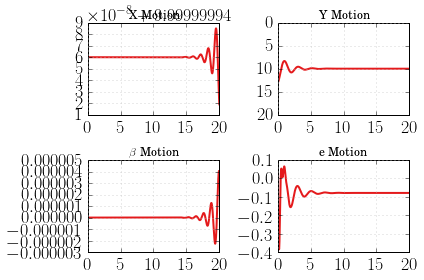

In [30]:
sim_time = np.linspace(0.0, 20, 999)

fig = plt.figure(0)
fig.add_subplot(221)
plt.plot(sim_time, response[:,0][:999], label='Unshaped')
# plt.ylim(25,0)
plt.title(r'X Motion')

fig.add_subplot(222)
plt.plot(sim_time, response[:,1][:999], label='Unshaped')
plt.ylim(20,0)
plt.title(r'Y Motion')

fig.add_subplot(223)
plt.plot(sim_time, np.degrees(response[:,2][:999]), label='Unshaped')
plt.title(r'$\beta$ Motion')

fig.add_subplot(224)
plt.plot(sim_time, response[:,3][:999], label='Unshaped')
# plt.ylim(25,0)
# plt.legend()
plt.title(r'e Motion')
# plt.xlabel(r'time (s)')
# plt.ylabel(r'meters')
plt.tight_layout()
plt.show()

In [31]:
# plt.plot(sim_time, response[:,1][:999], label='Unshaped')
# plt.ylim(25,0)
# plt.title(r'Y Motion')
# plt.show()

In [32]:
x_resp = response[:,0][:999]
y_resp = response[:,1][:999]
beta_resp = response[:,2][:999]
e_resp = response[:,3][:999]

# For the cables and top of rectangle
left_point_x = x_resp - (plate_width/2) * np.cos(beta_resp) + (plate_height/2) * np.sin(beta_resp)
left_point_y = y_resp - (plate_width/2) * np.sin(beta_resp) - (plate_height/2) * np.cos(beta_resp)

right_point_x = x_resp + (plate_width/2) * np.cos(beta_resp) + (plate_height/2) * np.sin(beta_resp)
right_point_y = y_resp + (plate_width/2) * np.sin(beta_resp) - (plate_height/2) * np.cos(beta_resp)

# For the bottom corner of the rectangle
# left_point_x_bottom = x_resp - (plate_width/2) * np.cos(beta_resp) - (plate_height/2) * np.sin(beta_resp)
# left_point_y_bottom  = y_resp - (plate_width/2) * np.sin(beta_resp) + (plate_height/2) * np.cos(beta_resp)

# right_point_x_bottom  = x_resp + (plate_width/2) * np.cos(beta_resp) - (plate_height/2) * np.sin(beta_resp)
# right_point_y_bottom  = y_resp + (plate_width/2) * np.sin(beta_resp) + (plate_height/2) * np.cos(beta_resp)

# For the Rod
# s_curve(sim_time, 0, 3, 1, 1)
bottom_x = (-(rod_length/2 - e_resp)*np.sin(beta_resp) + x_resp)
bottom_y = ((rod_length/2 - e_resp)*np.cos(beta_resp) + y_resp)

top_x = (-(-rod_length/2 - e_resp)*np.sin(beta_resp) + x_resp)
top_y = ((-rod_length/2 - e_resp)*np.cos(beta_resp) + y_resp)

# left_point_x = x_resp - (3/2) * np.cos(beta_resp)
# left_point_y = y_resp - (3/2) * np.sin(beta_resp)

# right_point_x = (20 - x_resp) + (3/2) * np.cos(beta_resp)
# right_point_y = y_resp + (3/2) * np.sin(beta_resp)

# right_point_x = left_point_x + 3

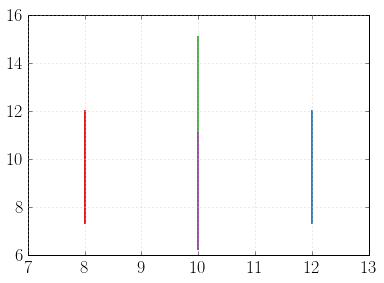

In [33]:
plt.plot(left_point_x, left_point_y)
plt.plot(right_point_x, right_point_y)
plt.plot(bottom_x, bottom_y)
plt.plot(top_x, top_y)
# plt.ylim(10,7)

In [34]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# fig1 = plt.figure()
# ax1 = fig1.add_subplot(111, aspect='equal')
# ax1.add_patch(patches.Rectangle((0.1, 0.1),0.5,0.5,))

Processing frame 0
Processing frame 30
Processing frame 60
Processing frame 90
Processing frame 120
Processing frame 150
Processing frame 180
Processing frame 210
Processing frame 240
Processing frame 270


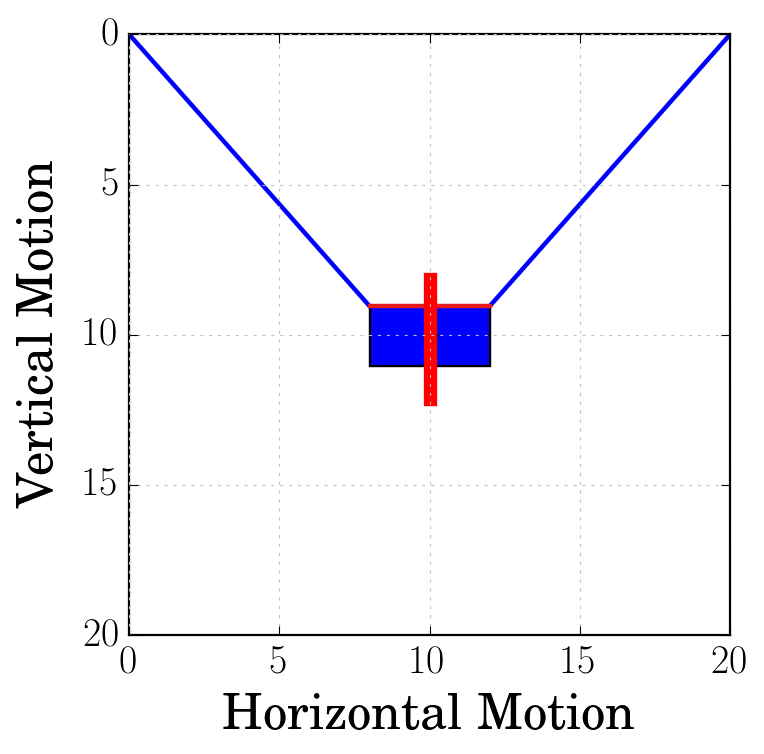

In [35]:
import matplotlib.animation as animation

# Change some plot properties to make the video work and look better
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
mpl.rcParams['savefig.dpi'] = 160
mpl.rcParams['savefig.bbox'] = 'standard'
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot(111)
plt.ylim(20,0)
plt.xlim(0,20)
plt.xlabel('Horizontal Motion', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Motion', fontsize=22, weight='bold', labelpad=10)
plt.axes().set_aspect('equal')

leftcable, = plt.plot([],[], linewidth=2, linestyle = '-', label='leftcable', color='b')
rightcable, = plt.plot([],[], linewidth=2, linestyle = '-', label='rightcable', color='b')
barLine, = plt.plot([],[], linewidth=2, linestyle = '-', label='Bar')
# plate = ax1.add_patch(patches.Rectangle((0, 0), plate_width, plate_height, angle=0))
patch = patches.Rectangle((0, 0), 0, 0, angle=0)
# rect = Rectangle(([], []), plate_width, plate_height, angle=[])
# ax.add_patch(rect)

centerG, = plt.plot([],[], 'ro', label='Center of Gravity')
rod,    = plt.plot([],[], linewidth=6, linestyle = '-', label='rod', color='r')

def init():
    """ Initialize the lines in the plot """
    leftcable.set_data([], [])
    rightcable.set_data([], [])
    barLine.set_data([],[])
    centerG.set_data([],[])
#     plate.set_data([],[],[])
    ax.add_patch(patch)
    rod.set_data([],[])

    return barLine, leftcable, rightcable, centerG, patch, rod,

def animate_un(i):
    """ Update the plot for frame i """
    if not (i % 30): # print notice every 30th frame
        print('Processing frame {}'.format(i))

    rightcable.set_data([0, left_point_x[i]], [0, left_point_y[i]])
    leftcable.set_data([20, right_point_x[i]], [0, right_point_y[i]])
    barLine.set_data([left_point_x[i], right_point_x[i]], [left_point_y[i], right_point_y[i]])
    centerG.set_data([x_resp[i]],[y_resp[i]])
#     plate.set_data([left_point_x_bottom[i], right_point_x_bottom[i]],
#                    [left_point_y_bottom[i], right_point_y_bottom[i]], [beta_resp[i]])
    patch.set_width(plate_width)
    patch.set_height(plate_height)
    patch.set_xy([left_point_x[i], left_point_y[i]])
    patch._angle = np.rad2deg(beta_resp[i])
    rod.set_data([bottom_x[i], top_x[i]],[bottom_y[i],top_y[i]])

    return barLine, leftcable, rightcable, centerG, patch, rod,

# def animate_s(i):
#     """ Update the plot for frame i """
#     if not (i % 30): # print notice every 30th frame
#         print('Processing frame {}'.format(i))

#     rightcable.set_data([0, x_s[i]], [0, y_s[i]])
#     leftcable.set_data([20, x_s[i]], [0, y_s[i]])
#     barLine.set_data([x_s[i], xend_s[i]], [y_s[i], yend_s[i]])

#     return barLine, leftcable, rightcable,

ani_un = animation.FuncAnimation(fig, animate_un, interval = 30, frames = 300,
                                 blit = True, init_func = init)
# ani_s = animation.FuncAnimation(fig, animate_s, interval = 30, frames = 300,
#                                 blit = True, init_func = init)

ani_un.save('/Users/forrest/Desktop/unshaped3.mp4', bitrate = 2500, fps = 30)
# ani_s.save('ZVEI2mode.mp4', bitrate = 2500, fps = 30)

In [ ]:
####### Variables to Change ##############

# Beginning Point
X_begin = 14
Y_begin = 7.5

# Ending Point
X_end = 10
Y_end = 7.5

# Time to get to Point
Risetime = 6.0

# Time to start Moving
time_begin = 1.0

# Mass
mass = 10.0

# K of Cables
cable_K = 100.0

# C of Cables
cable_C = 10.0

# K of Rod
rod_K = 10.0

# C of Rod
rod_C = 1.0

# width of plate
width = 4.0

# height of plate
height = 3.0

# Time to plot response
endtime = 50.0
#########################################

inertia = (width**2 + height**2) * (mass/12.0) 

def Lengths(x,y):
    k=100
    h=20
    m=10.0
    Fy = np.array([[k*y/np.sqrt(x**2 + y**2), k*y/np.sqrt(y**2 + (h - x)**2)],
                   [k*x/np.sqrt(x**2 + y**2), -h*k/np.sqrt(y**2 + (h - x)**2
                    )+k*x/np.sqrt(y**2 + (h - x)**2)]])
    a = np.array([2*k*y - 9.81*m,-h*k + 2*k*x])
    x = np.linalg.solve(Fy,a)
    return x

In [ ]:
L1_begin, L2_begin = Lengths(X_begin, Y_begin)
L1_end, L2_end = Lengths(X_end, Y_end)


def s_curve(CurrTime, Begin, Amp, RiseTime, StartTime):
    """
    This was copied from Dr. Vaughan's Input shaping Library
    I edited it to allow for a beginning value.

    Function to generate an s-curve command

    Arguments:
      CurrTime : The current timestep or an array of times
      Amp : The magnitude of the s-curve (or final setpoint)
      RiseTime : The rise time of the curve
      StartTime : The time that the command should StartTime
      Begin : The beginnning value

    Returns :
      The command at the current timestep or an array representing the command
      over the times given (if CurrTime was an array)
    """

    Amp = Amp - Begin
    scurve = 2.0 * ((CurrTime - StartTime)/RiseTime)**2 * (CurrTime-StartTime >= 0) * (CurrTime-StartTime < RiseTime/2)             +(-2.0 * ((CurrTime - StartTime)/RiseTime)**2 + 4.0 * ((CurrTime - StartTime)/RiseTime) - 1.0) * (CurrTime-StartTime >= RiseTime/2) * (CurrTime-StartTime < RiseTime)             + 1.0 * (CurrTime-StartTime >= RiseTime)

    return (Amp * scurve) + Begin


# Various Shapers

# Going with 500rpm
# example_shaper = shaping.EI(0.329, 0.101)
example_shaper = shaping.ZV_EI_2mode(0.25946057132, 0.00869237035333, 0.47558317356, 0.203271432775)
# example_shaper = shaping.ZVD(0.32, 0.032272678421545214)
# example_shaper = shaping.ZV_EI_2mode(.466053, 0.032272, .466053, 0.032272)
# example_shaper = shaping.UMZVD(.46605358040201028, 0.032272678421545214)
# example_shaper = shaping.ZVD_2mode(0.40160804, 0.07159188, 0.047746, 0.0)
Shaper = example_shaper.shaper

# a = shaping.shaped_input(s_curve, t, Shaper, 10.0,13.0,5.0,3.0)


# length_of_rod = 3.0
# mass = 1.0
# inertia = length_of_rod**2 * (1.0/3.0) * mass

############### UNSHAPED #####################################################

# Define the states and state vector
w1, w2, w3, w4, w5, w6 = sympy.symbols('w1 w2 w3 w4 w5 w6', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t), w5(t), w6(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              y : w2(t),
              beta: w3(t),
              x_dot: w4(t),
              y_dot: w5(t),
              beta_dot: w6(t),
              m : mass,
              g : 9.81,
              k : cable_K,
              L_1_init:s_curve(t, L1_begin, L1_end, Risetime, time_begin),
              L_2_init:s_curve(t, L2_begin, L2_end, Risetime, time_begin),
              H : 20.0,
              c : cable_C,
              a : width,
              b : height,
              Izz: inertia}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w),
                              lrhs.subs(sub_params),
                              modules = mat2array)


x0 = [X_begin, Y_begin, 0.0, 0.0, 0.0, 0.0]

# Positive beta is to the left when facing the structure
sim_time = np.linspace(0.0, endtime, 1000)


# In[33]:

# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])

# define the sample time
dt = sim_time[1] - sim_time[0]

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

# np.savetxt("response.csv", response, delimiter=",")
# np.savetxt("response_shaped.csv", response2, delimiter=",")
# np.savetxt("sim_time.csv", sim_time, delimiter=",")

#############################################################################

############### SHAPED ######################################################

# Define the states and state vector
w1, w2, w3, w4, w5, w6 = sympy.symbols('w1 w2 w3 w4 w5 w6', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t), w5(t), w6(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              y : w2(t),
              beta: w3(t),
              x_dot: w4(t),
              y_dot: w5(t),
              beta_dot: w6(t),
              m : mass,
              g : 9.81,
              k : cable_K,
              L_1_init: shaping.shaped_input(s_curve, t, Shaper, L1_begin, L1_end, Risetime, time_begin),
              L_2_init: shaping.shaped_input(s_curve, t, Shaper, L2_begin, L2_end, Risetime, time_begin),
              H : 20.0,
              c : cable_C,
              a : width,
              b : height,
              Izz: inertia}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w),
                              lrhs.subs(sub_params),
                              modules = mat2array)

x0 = [X_begin, Y_begin, 0.0, 0.0, 0.0, 0.0]

# Positive beta is to the left when facing the structure
sim_time = np.linspace(0.0, endtime, 1000)


# In[33]:

# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])

# define the sample time
dt = sim_time[1] - sim_time[0]

# pre-populate the response array with zeros
response2 = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response2[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

# The solver kept putting a zero at the end of the responses so I deleted the
# final value
# response = response[:998]
# response2 = response2[:998]
# sim_time = sim_time[:998]
#############################################################################

In [ ]:
sns.set_palette("Paired")
sns.set_context("talk", font_scale=1.2)
# sns.set_style("darkgrid")

plt.figure(0)
# plt.subplot(211)
plt.plot(sim_time, response[:,1], label=r'Unshaped')
plt.plot(sim_time, response2[:,1], label =r'Shaped')
# plt.ylim(25,0)
plt.legend()
plt.title(r'Y Motion')
plt.xlabel(r'time (s)')
plt.ylabel(r'meters')
plt.show()

plt.figure(1)
# plt.subplot(211)
plt.plot(sim_time, response[:,0], label='Unshaped')
plt.plot(sim_time, response2[:,0], label ='Shaped')
plt.legend()
plt.title('X Motion')
plt.xlabel('time (s)')
plt.ylabel('meters')
plt.show()

plt.figure(2)
# plt.subplot(211)
plt.plot(sim_time, np.degrees(response[:,2]), label='Unshaped')
plt.plot(sim_time, np.degrees(response2[:,2]), label ='Shaped')
plt.legend()
# plt.plot(sim_time, np.degrees(response2[:,2]))
# plt.ylim(-15,15)
# plt.xlim(0,60)
plt.title('Beta Motion')
plt.xlabel('time (s)')
plt.ylabel('Degrees')
# plt.savefig("Beta_Motion.pdf")
plt.show()

In [ ]:
n=3
for i in range(n):
    wi = sympy.symbols('wi', cls=sympy.Function)

In [ ]:
tree=0
yt=0
a = {tree:9, yt:5}

In [ ]:
n, waste = LM.q.shape
m = 2*n
m-=1
n-=1
for i in range(m):
    w_i = sympy.symbols('w'+ str(i), cls=sympy.Function)
for i in range(n):
    q_i = LM.q[i]
for i in range(n):
    ui = LM.u[i]

In [ ]:
n = 3
for i in range(n):
    qi = LM.q[i]

In [ ]:
n, waste = LM.q.shape

In [ ]:
i

In [ ]:
def Lengths2(x,y):
    theta = 0.0
    a = 4.0
    k=10
    h=20
    m=1.0
    L_1 = np.sqrt((x-(a/2)*np.cos(theta))**2 + (y-(a/2)*np.sin(theta))**2)
    L_2 = np.sqrt(((h-x)+(a/2)*np.cos(theta))**2 + (y+(a/2)*np.sin(theta))**2)
    Fy = np.array([[k*y/L_1, k*y/L_2],
                   [k*x/L_1, -h*k/L_2+k*x/L_2]])
    a = np.array([2*k*y - 9.81*m,-h*k + 2*k*x])
    x = np.linalg.solve(Fy,a)
    return x

In [ ]:
Lengths2(10, 7.5)